In [1]:
#General libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm, multivariate_normal
from IPython.display import clear_output
import time

#Own code
from utils.data_utils import create_data, create_dgp_data, transformation, standardize
from utils.tvp_models import TVPVARModel

# Suppress scientific notation in numpy
np.set_printoptions(suppress=True)

In [2]:
train = 200

M = 3
p = 4
T = train - p
k = M*(M*p+1)

print("k: " + str(k))

np.random.seed(12345)

k: 39


In [3]:
ds = pd.read_csv("data/fred_qd.csv")

In [4]:
transform=True

gdp = transformation(ds["GDPC1"].iloc[2:].to_numpy(), 5, transform)
cpi = transformation(ds["CPIAUCSL"].iloc[2:].to_numpy(), 6, transform)
fedfund = transformation(ds["FEDFUNDS"].iloc[2:].to_numpy(), 2, transform)
compi = transformation(ds["PPIACO"].iloc[2:].to_numpy(), 6, transform)
borrowings = transformation(ds["TOTRESNS"].iloc[2:].to_numpy(), 6, transform)
sp500 = transformation(ds["S&P 500"].iloc[2:].to_numpy(), 5, transform)
m2 = transformation(ds["M2REAL"].iloc[2:].to_numpy(), 5, transform)

series_total = [gdp, cpi, fedfund]
#series_total = [gdp, cpi, fedfund, compi, borrowings , sp500, m2]

In [5]:
standardized_series = standardize(series_total, train)

In [6]:
# Create matrices from FED-QD
X, y = create_data(standardized_series, train, T, M, p, k)

In [7]:
# # SVSS
# tvp_svss = TVPVARModel(X, y, p, train)
# mt1t_svss, St1t_svss = tvp_svss.train(print_status=False)

# # Horseshoe
# tvp_horseshoe = TVPVARModel(X, y, p, train)
# tvp_horseshoe.initialize_priors(prior='horseshoe')
# mt1t_horseshoe, St1t_horseshoe = tvp_horseshoe.train(print_status=False)

# # Lasso
# tvp_lasso = TVPVARModel(X, y, p, train)
# tvp_lasso = tvp_lasso.initialize_priors(prior='lasso')
# mt1t_lasso, St1t_lasso = tvp_horseshoe.train(print_status=False)

In [8]:
complete_T = cpi.shape[0]
X_complete, y_complete = create_data(standardized_series, complete_T, complete_T-p, M, p, k)

In [9]:
tvp_svss = TVPVARModel(X_complete, y_complete, p, train)
mt1t_svss, St1t_svss = tvp_svss.train(print_status=False)

/Users/cavriends/Dropbox/ESE/MSc Econometrics/Thesis/Bayesian VARs/Code/Jupyter/utils/tvp_models.py:201: RuntimeWarning: divide by zero encountered in true_divide
  gamma         = 1/(np.multiply(1+(np.divide((1-self.pi0),self.pi0)),np.exp(l_0-l_1)))
/Users/cavriends/Dropbox/ESE/MSc Econometrics/Thesis/Bayesian VARs/Code/Jupyter/utils/tvp_models.py:201: RuntimeWarning: invalid value encountered in true_divide
  gamma         = 1/(np.multiply(1+(np.divide((1-self.pi0),self.pi0)),np.exp(l_0-l_1)))


In [10]:
tvp_svss.prior

'svss'

In [11]:
X_complete.shape

(241, 3, 39)

In [103]:
tvp_lasso = TVPVARModel(X_complete, y_complete, p, train)
tvp_lasso.initialize_priors(prior='svss')
mt1t_lasso, St1t_lasso = tvp_lasso.train(print_status=False)

In [91]:
tvp_lasso.X[196]@mt1t_lasso[:,-1] 

array([-2.97549152, -1.50042485, -1.06928701])

In [158]:
mvn = multivariate_normal(mean=mt1t_lasso[:,-1], cov=St1t_lasso[:,:,-1], allow_singular=True)

In [172]:
test = mvn.rvs(size=500000)

In [169]:
forecasting_density = (tvp_lasso.X[196]@test.T)

(array([   1.,    0.,    1.,    0.,    2.,    0.,    0.,    0.,    1.,
           0.,    1.,    0.,    1.,    1.,    2.,    0.,    3.,    3.,
           3.,    6.,    1.,    6.,    5.,    4.,    5.,    6.,   13.,
          11.,    9.,   15.,   18.,   11.,   18.,   25.,   11.,   19.,
          13.,   26.,   30.,   42.,   46.,   54.,   85.,   78.,   76.,
          74.,   77.,   78.,  100.,  118.,  127.,  161.,  155.,  145.,
         184.,  229.,  226.,  234.,  269.,  284.,  298.,  358.,  332.,
         409.,  369.,  431.,  487.,  527.,  504.,  588.,  573.,  696.,
         669.,  667.,  755.,  779.,  846.,  872.,  918.,  985., 1041.,
        1064., 1089., 1164., 1225., 1269., 1323., 1293., 1373., 1378.,
        1396., 1464., 1449., 1487., 1511., 1504., 1523., 1605., 1572.,
        1664., 1663., 1709., 1690., 1640., 1672., 1641., 1623., 1723.,
        1667., 1687., 1628., 1575., 1609., 1554., 1413., 1473., 1474.,
        1421., 1387., 1363., 1305., 1309., 1334., 1245., 1138., 1161.,
      

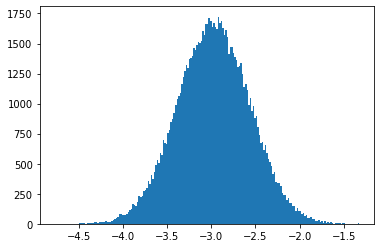

In [176]:
plt.hist(forecasting_density[0], bins=200)

In [178]:
tvp_lasso.X[196]@mt1t_lasso[:,-1]

array([-2.97549152, -1.50042485, -1.06928701])

In [179]:
np.median(forecasting_density[0])

-2.973407358491596

In [86]:
tvp_lasso.calculate_msfe(8)

array([0.26436064, 0.35199176, 0.51628555, 0.6467324 , 0.59659313,
       0.82699062, 1.06838994, 1.4000044 ])

In [17]:
np.mean((predictions[:,0,0]-y_complete[196:,0])**2)

0.4228061423660028

In [13]:
predictions = tvp_lasso.calculate_predictions(8)

In [21]:
predictions[:,1,0]

array([-3.52435959, -1.64545947, -2.14470146, -0.31350577,  1.34285698,
       -1.00848119, -0.73670551, -0.65372407, -0.26752467, -0.32557831,
       -0.32302324, -1.20977412, -1.18051668, -0.67281291, -0.58585857,
       -0.67803964, -0.195125  , -0.82168384, -1.54264872, -0.89144008,
       -0.92601679, -0.69445856, -0.82483504, -1.10004419, -1.12325758,
       -1.65520288, -0.81630854, -0.7489487 , -1.45703781, -1.25554782,
       -0.75344903, -0.95676573, -0.81609622, -0.57931139, -1.29462399,
       -0.71128229, -0.09698092, -0.75401537, -0.74382719, -0.55577814,
       -0.61054747, -0.71157039, -0.37066023, -0.53933345, -0.37232188])

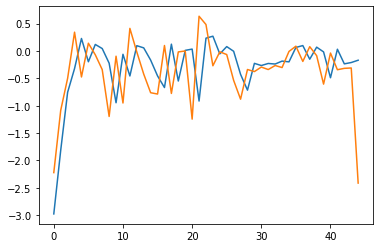

In [51]:
plt.plot(predictions[:,0,0])
plt.plot(y_complete[196:,0])

In [56]:
tvp_test = TVPVARModel(X_complete, y_complete, p, 200)
mt1t, St1t = tvp_test.train(print_status=False)

In [72]:
tvp_test.X[196]@mt1t[:,-1]

array([-2.97549152, -1.50042485, -1.06928701])

In [75]:
tvp_test.X[196]@mt1t[:,-1]

array([-2.97549152, -1.50042485, -1.06928701])

In [84]:
np.mean((y_complete[196:] - predictions[:,:,0])**2)

0.2643606407850807

In [33]:
np.mean((predictions[:,0,0] - y_complete[196:,0])**2)

0.5151178622047449

In [ ]:
y_pred = np.empty((T,M))

for m in range(M):

    for t in range(T):

        y_pred[t,m] = X[t,m,:]@mt1t_svss[:,t]

In [ ]:
def calculate_predictions(total_h, current_X, mt1t):

    prev_X = current_X

    prev_pred = np.zeros((M,total_h))

    for h in range(total_h):

        prev_pred[:,h] = prev_X@mt1t[:,-1]
        vec_X = prev_X[0,:(M*p+1)]

        empty_X = np.zeros((M*p+1))
        empty_X[0] = 1

        for m in range(M):
            empty_X[(m*p+2):((m+1)*p+1)] = vec_X[(m*p+1):((m+1)*p)]

        vec_X = empty_X
        vec_X[1::p] = prev_pred[:,h]

        prev_X = np.zeros((M,k))
        for m in range(M):
            total_lags = M*p+1
            prev_X[m,m*(total_lags):(m+1)*total_lags] = vec_X

    return prev_pred

In [ ]:
def calculate_msfe(X_complete, y_complete, p, train_begin=200, complete_T=243, total_h=8, prior='svss', prior_parameters={'tau_0':0.1, 'tau_1':10, 'pi0':0.5} ,homoskedastic=True):

    y_pred = np.zeros((complete_T-train_begin,M,total_h))
    counter = 0
    MSFE_TVP = np.zeros(total_h)
    for idx, t in enumerate(range(train_begin, complete_T)):

        train_T = t-p
        X_train = X_complete[:train_T]
        y_train = y_complete[:train_T]
        counter += 1
        mt1t, St1t = tvp_var_vb(X_train, y_train, train_T, M, p, k, prior=prior, homoskedastic=homoskedastic, prior_parameters=prior_parameters, prior_default=False, print_status=False)

        y_pred[idx] = calculate_predictions(total_h, X_complete[train_T], mt1t)
    
    for h in range(total_h):
        if h == 0:
            MSFE_TVP[h] = np.mean((y_complete[train_begin-p:]-y_pred[:,:,0])**2)
        else:
            MSFE_TVP[h] = np.mean((y_complete[train_begin-p+h:]-y_pred[:-h,:,h])**2)
            
    return MSFE_TVP

In [ ]:
# for h in range(total_h):
#     if h == 0:
#         MSFE_TVP = np.mean((y_complete[train_begin-p:]-y_pred[:,:,0])**2)
#         MSFE_RW = np.mean((y_complete[train_begin-p:]-y_complete[train_begin-p-1:-1])**2)
#     else:
#         MSFE_TVP = np.mean((y_complete[train_begin-p+h:]-y_pred[:-h,:,h])**2)
#         MSFE_RW = np.mean((y_complete[train_begin-p:]-y_complete[train_begin-p-(h+1):-(h+1)])**2)
              
#     print(str(h+1) + "-step ahead" + "\n" + "MSFE TVP-VAR: " + "\t" + str(round(MSFE_TVP,4)) + "\n" + "MSFE RW: " + "\t" + str(round(MSFE_RW,4)) + "\n" + "Ratio: " + str(round(MSFE_TVP/MSFE_RW,4)))

In [ ]:
# %%time

# lambda_values = np.arange(50,51,0.5)
# derivative_values = np.zeros(lambda_values.shape[0])
# error = np.sqrt(1.1e-16)

# for idx, lambda_value in enumerate(lambda_values):
                                   
#     derivative_values[idx] = (calculate_msfe(X_complete, y_complete, p, prior='lasso', prior_parameters={'lambda_param':lambda_value+error})[0] - calculate_msfe(X_complete, y_complete, p, prior='lasso', prior_parameters={'lambda_param':lambda_value-error})[0])/(2*error)
#     print(idx)

In [ ]:
def insample_msfe(X_complete, y_complete, p, train_begin=200, complete_T=243, total_h=8, prior='svss', prior_parameters={'tau_0':0.1, 'tau_1':10, 'pi0':0.5} ,homoskedastic=True):
    
    M = X_complete.shape[1]
    k = X_complete.shape[2]
    
    train_T = train_begin-p
    X_train = X_complete[:train_T]
    y_train = y_complete[:train_T]
    
    tvp_var = TVPVARModel(X_train, y_train)
    tvp_var.initialize_priors(prior, prior_parameters, False)
    mt1t, St1t = tvp_var.train(print_status=False)
    
    y_pred = np.empty((train_T,M))

    for m in range(M):

        for t in range(train_T):

            y_pred[t,m] = X_train[t,m,:]@mt1t[:,t]
            
    msfe = np.mean((y_pred - y_complete[:train_T])**2)
    
    return msfe

In [ ]:
def point_prediction(X_complete, y_complete, p, train_begin=242, complete_T=243, prior='svss', prior_parameters={'tau_0':0.1, 'tau_1':10, 'pi0':0.5} ,homoskedastic=True):
    
    M = X_complete.shape[1]
    k = X_complete.shape[2]
    
    train_T = train_begin-p
    X_train = X_complete[:train_T]
    y_train = y_complete[:train_T]
    
    tvp_var = TVPVARModel(X_train, y_train)
    tvp_var.initialize_priors(prior, prior_parameters, False)
    mt1t, St1t = tvp_var.train(print_status=False)
    
    y_pred = np.empty((train_T,M))

    for m in range(M):

        for t in range(train_T):

            y_pred[t,m] = X_train[t,m,:]@mt1t[:,t]
    
    return y_pred

In [ ]:
train_T = 242

X_train = X_complete[:train_T]
y_train = y_complete[:train_T]

tvp_var = TVPVARModel(X_train, y_train)
mt1t, St1t = tvp_var.train(print_status=False)



In [ ]:
def point_prediction_full(X_complete, y_complete, p, prior='svss', prior_parameters={'tau_0':0.1, 'tau_1':10, 'pi0':0.5} ,homoskedastic=True):
    
    M = X_complete.shape[1]
    k = X_complete.shape[2] 
    
    X = X_complete[:-1]
    y = y_complete[:-1]
    
    tvp_var = TVPVARModel(X, y)
    tvp_var.initialize_priors(prior, prior_parameters, False)
    mt1t, St1t = tvp_var.train(print_status=False)
    
    pred = np.zeros(M)
    
    for m in range(M):
        pred[m] = X[-1,m,:]@mt1t[:,-1]
        
    return pred

In [ ]:
import os

def calculate_derivative (parameter_value):
    error = np.sqrt(1.1e-16)
    derivative = (calculate_msfe(X_complete, y_complete, p, prior='lasso', prior_parameters={'lambda_param':parameter_value+error})[0] - calculate_msfe(X_complete, y_complete, p, prior='lasso', prior_parameters={'lambda_param':parameter_value-error})[0])/(2*error)
    print('lambda: ' + str(parameter_value) + " is done!" + "\n" + "process ID: " + str(os.getpid()))
    return derivative

In [ ]:
%%time
import os
from multiprocessing import Pool, Array

lambda_values = np.arange(50,51,0.20)

if __name__ == '__main__':
    
    pool = Pool()
    derivatives = pool.map(calculate_derivative, lambda_values)

In [ ]:
import pickle

with open('derivatives.pkl', 'wb') as f:
    pickle.dump(derivatives, f, pickle.HIGHEST_PROTOCOL)

In [ ]:
def calculate_derivative_insample (parameter_value):
    error = np.sqrt(1.1e-16)
    derivative = (insample_msfe(X_complete, y_complete, p, prior='lasso', prior_parameters={'lambda_param':parameter_value+error}) - insample_msfe(X_complete, y_complete, p, prior='lasso', prior_parameters={'lambda_param':parameter_value-error}))/(2*error)
    return derivative

In [ ]:
%%time
import os
from multiprocessing import Pool, Array
from functools import partial

lambda_values = np.arange(50,51,0.025)
print(lambda_values.shape[0])

if __name__ == '__main__':
    
    pool = Pool()
    derivatives = pool.map(calculate_derivative_insample, lambda_values)

In [ ]:
plt.plot(lambda_values, derivatives)

In [ ]:
def calculate_derivative_point_gdp(parameter_value):
    error = np.sqrt(1.1e-16)
    derivative = (point_prediction_full(X_complete, y_complete, p, 'lasso', {'lambda_param':parameter_value+error})[0] - point_prediction_full(X_complete, y_complete, p, 'lasso', {'lambda_param':parameter_value-error})[0])/(2*error)
    return derivative

In [ ]:
calculate_derivative_point_gdp(50)

In [ ]:
%%time
import os
from multiprocessing import Pool, Array
from functools import partial

lambda_values = np.arange(30,400,0.50)
print(lambda_values.shape[0])

if __name__ == '__main__':
    
    pool = Pool()
    derivatives = pool.map(calculate_derivative_point_gdp, lambda_values)

In [ ]:
plt.plot(lambda_values, derivatives)

In [ ]:
import pickle

with open('derivatives.pkl', 'wb') as f:
    pickle.dump(derivatives, f, pickle.HIGHEST_PROTOCOL)